## Load Libraries

In [0]:
!pip install pycaret[full]
!pip install -U threadpoolctl

  Obtaining dependency information for pycaret[full] from https://files.pythonhosted.org/packages/3e/6f/b3d59fac3869a7685e68aecdd35c336800bce8c8d3b45687bb82cf9a2848/pycaret-3.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for tqdm>=4.62.0 from https://files.pythonhosted.org/packages/d0/30/dc54f88dd4a2b5dc8a0279bdd7270e735851848b762aeb1c1184ed1f6b14/tqdm-4.67.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/57.7 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 2.4 MB/s eta 0:00:00
  Obtaining dependency information for jinja2>=3 from https://files.pythonhosted.org/packages/62/a1/3d680cbfd5f4b8f15abc1d571870c5fc3e594bb582bc3b64ea099db13e56/jinja2-3.1.6-py3-none-any.whl.metadata
  Obtaining dependency information for scikit-learn>1.4.0 from https://files.pythonhosted.org/packages/c6/38/48b75c3d8d268a3f19837cb8a89155ead6e97c6892bb64837183ea41db2b/scikit_learn-1.7.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_

In [0]:
dbutils.library.restartPython()

In [0]:
import warnings
import shap
import numpy as np
warnings.filterwarnings('ignore')

## Load dataset and create experiment

In [0]:
ml_df_class = spark.table('hive_metastore.default.hse_cc_pred_ml_2').toPandas().drop(columns=['number_of_near_miss_incidents'])
ml_df_class['random_feature'] = np.random.rand(len(ml_df_class))

In [0]:
from pycaret.classification import *

s = setup(
    ml_df_class, 
    target="is_near_miss", 
    # ignore_features = ['production_date'],
    fix_imbalance=True, 
    normalize=True, 
    transformation=True,
    memory=False,
    session_id=8933
)

,Description,Value
0,Session id,8933
1,Target,is_near_miss
2,Target type,Binary
3,Original data shape,"(5642, 28)"
4,Transformed data shape,"(9453, 49)"
5,Transformed train set shape,"(7760, 49)"
6,Transformed test set shape,"(1693, 49)"
7,Numeric features,24
8,Categorical features,3
9,Preprocess,True


In [0]:
X_train, X_test, y_train, y_test = get_config('X_train'), get_config('X_test'), get_config('y_train'), get_config('y_test')
X_train['is_near_miss'] = y_train
X_test['is_near_miss'] = y_test
X_train_spark = spark.createDataFrame(X_train)
X_test_spark = spark.createDataFrame(X_test)

X_train_spark.write.format('delta').mode('overwrite').option('overwriteSchema', 'true').saveAsTable('hive_metastore.default.hse_cc_inc_pred_ml_train')
X_test_spark.write.format('delta').mode('overwrite').option('overwriteSchema', 'true').saveAsTable('hive_metastore.default.hse_cc_inc_pred_ml_test')

## Fit Models

In [0]:
#best = compare_models(sort='F1', exclude=['lightgbm','svm','lda','ridge','knn'], n_select=3)
#best = compare_models(include=['rf', 'et', 'gbc'], sort='F1', n_select=3)
best = compare_models(
    sort='F1',
    n_select=3,
    exclude=[
        'sgd',         # SGDClassifier – often returns read-only arrays
        'ridge',       # RidgeClassifier – no predict_proba, causes issues
        'svm',         # SVM with hinge loss – same issue
        'lda',         # LinearDiscriminantAnalysis – returns readonly NumPy
        'qda',         # Same as LDA
        'nb',          # Naive Bayes – numeric instability
        'dummy',       # Dummy classifier – useless
        'xgboost',     # May use read-only arrays in some versions
        'catboost',    # Can have compatibility issues in some installs
        'lightgbm',
        'ada'     # Already excluded by you
    ]
)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9314,0.8380,0.2714,0.0743,0.1159,0.0916,0.1138,0.687
knn,K Neighbors Classifier,0.9415,0.5972,0.1738,0.0651,0.0936,0.0703,0.0798,0.089
gbc,Gradient Boosting Classifier,0.9552,0.7806,0.1000,0.0602,0.0746,0.0538,0.0555,0.488
dt,Decision Tree Classifier,0.9602,0.5237,0.0714,0.0494,0.0583,0.0391,0.0397,0.101
et,Extra Trees Classifier,0.9714,0.7675,0.0286,0.0417,0.0336,0.0197,0.0202,0.155
rf,Random Forest Classifier,0.9719,0.7316,0.0143,0.0200,0.0167,0.0037,0.0033,0.209



Processing: 100%|██████████| 27/27 [00:19<00:00,  1.67it/s]
                                                           

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

In [0]:
best

[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=8933, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                      weights='uniform'),
 GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='log_loss', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_samples_leaf=1,
                            min_samples_split=2, min_weight_fraction_leaf=0.0,
                            n_estimators=100, n_iter_no_change=None,
                            ra

In [0]:
# # Ensure models are in writeable state
# for model in best:
#     if hasattr(model, 'steps'):  # Pipeline check
#         for step_name, step_obj in model.steps:
#             if hasattr(step_obj, '__dict__'):
#                 for attr_name, attr_value in step_obj.__dict__.items():
#                     if hasattr(attr_value, 'flags') and hasattr(attr_value.flags, 'writeable'):
#                         attr_value.flags.writeable = True
best_ensemble = stack_models(best, choose_better=True, optimize='F1')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9722,0.7993,0.0000,0.0000,0.0000,-0.0131,-0.0136
1,0.9696,0.7482,0.0000,0.0000,0.0000,-0.0150,-0.0152
2,0.9620,0.7544,0.1429,0.1000,0.1176,0.0989,0.1005
3,0.9620,0.8770,0.0000,0.0000,0.0000,-0.0193,-0.0193
4,0.9595,0.8660,0.1429,0.0909,0.1111,0.0914,0.0939
5,0.9570,0.8428,0.0000,0.0000,0.0000,-0.0213,-0.0216
6,0.9671,0.8457,0.1429,0.1250,0.1333,0.1166,0.1169
7,0.9620,0.7706,0.1429,0.1000,0.1176,0.0989,0.1005
8,0.9671,0.7636,0.0000,0.0000,0.0000,-0.0166,-0.0167



Processing:  83%|████████▎ | 5/6 [00:22<00:04,  4.52s/it]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]


Processing: 100%|██████████| 6/6 [00:38<00:00,  7.11s/it]
                                                         

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Original model was better than the stacked model, hence it will be returned. NOTE: The display metrics are for the stacked model (not the original one).


In [0]:
# from sklearn.ensemble import StackingClassifier
# from sklearn.linear_model import LogisticRegression

# # Extract the actual estimators from PyCaret models
# estimators = [(f'model_{i}', model) for i, model in enumerate(best)]

# # Create stacking classifier manually
# best_ensemble = StackingClassifier(
#     estimators=estimators,
#     final_estimator=LogisticRegression(),
#     cv=5,
#     n_jobs=-1
# )

# # Fit manually
# X_train, y_train = get_config('X_train'), get_config('y_train')
# best_ensemble.fit(X_train, y_train)

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
File <command-1817494140045047>, line 10
      1 # # Ensure models are in writeable state
      2 # for model in best:
      3 #     if hasattr(model, 'steps'):  # Pipeline check
   (...)
      7 #                     if hasattr(attr_value, 'flags') and hasattr(attr_value.flags, 'writeable'):
      8 #                         attr_value.flags.writeable = True
---> 10 best_ensemble = stack_models(best, choose_better=True, optimize='F1')

File /local_disk0/.ephemeral_nfs/envs/pythonEnv-29b5c331-6753-436c-a66b-4dc03c54c619/lib/python3.11/site-packages/pycaret/utils/generic.py:964, in check_if_global_is_not_none.<locals>.decorator.<locals>.wrapper(*args, **kwargs)
    962     if globals_d[name] is None:
    963         raise ValueError(message)
--> 964 return func(*args, **kwargs)

File /local_disk0/.ephemeral_nfs/envs/pythonEnv-29b5c331-67

In [0]:
best_ensemble_tuned = tune_model(best_ensemble, choose_better=True, optimize='F1', search_library='optuna')
# # Skip stacking entirely and just tune the best individual model
# best_individual = best[0]  # Take the best performing model
# best_ensemble_tuned = tune_model(best_individual, choose_better=True, optimize='F1', search_library='optuna')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9519,0.7883,0.1429,0.0714,0.0952,0.0733,0.0780
1,0.9316,0.8369,0.2857,0.0833,0.1290,0.1045,0.1265
2,0.9316,0.8630,0.4286,0.1154,0.1818,0.1583,0.1965
3,0.9342,0.9462,0.5714,0.1481,0.2353,0.2131,0.2678
4,0.9165,0.9039,0.4286,0.0938,0.1538,0.1285,0.1711
5,0.9342,0.8299,0.0000,0.0000,0.0000,-0.0266,-0.0302
6,0.9418,0.8505,0.4286,0.1364,0.2069,0.1850,0.2184
7,0.9266,0.7585,0.1429,0.0417,0.0645,0.0381,0.0462
8,0.9342,0.8601,0.2857,0.0870,0.1333,0.1091,0.1305



Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]


Processing:  86%|████████▌ | 6/7 [02:20<00:19, 19.38s/it]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]


Processing: 100%|██████████| 7/7 [02:30<00:00, 17.29s/it]
                                                         

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

''

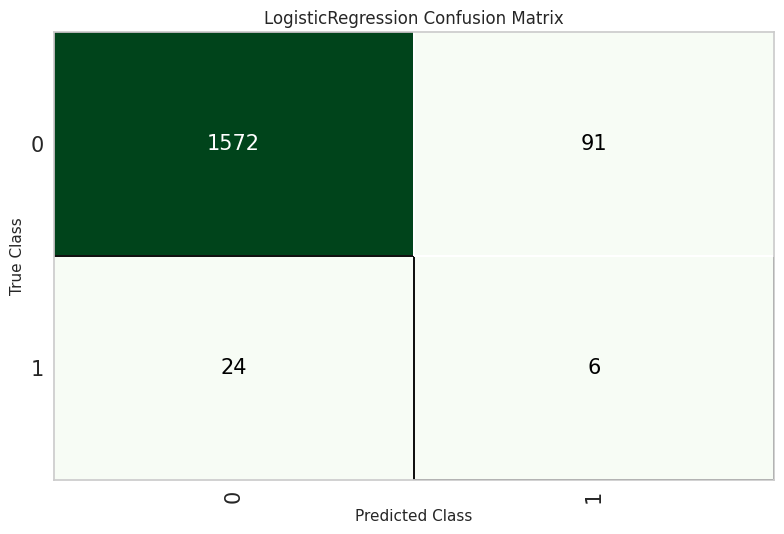

In [0]:
plot_model(best_ensemble_tuned, plot='confusion_matrix')

''

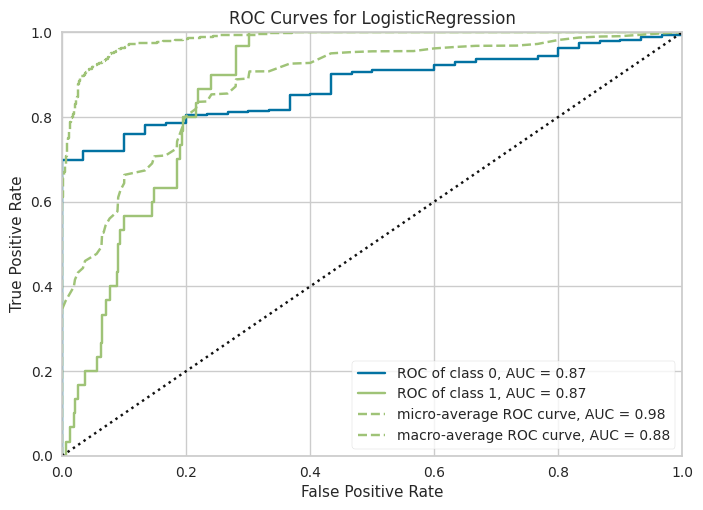

In [0]:
plot_model(best_ensemble_tuned, plot='auc')

''

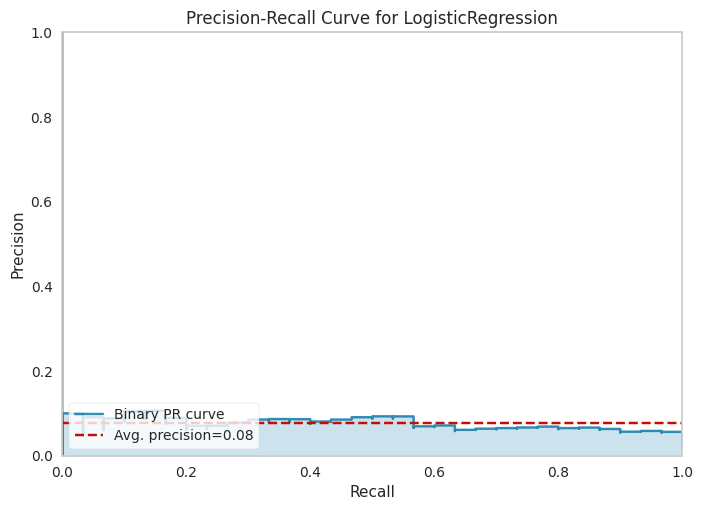

In [0]:
plot_model(best_ensemble_tuned, plot='pr')

''

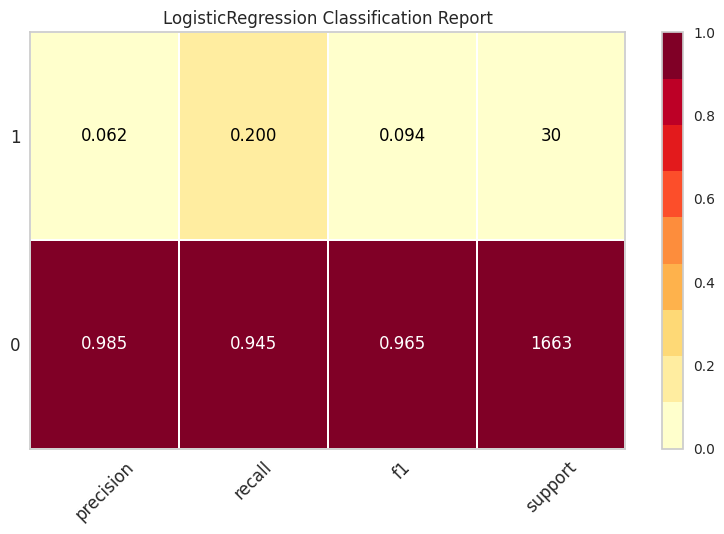

In [0]:
plot_model(best_ensemble_tuned, plot='class_report')

''

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

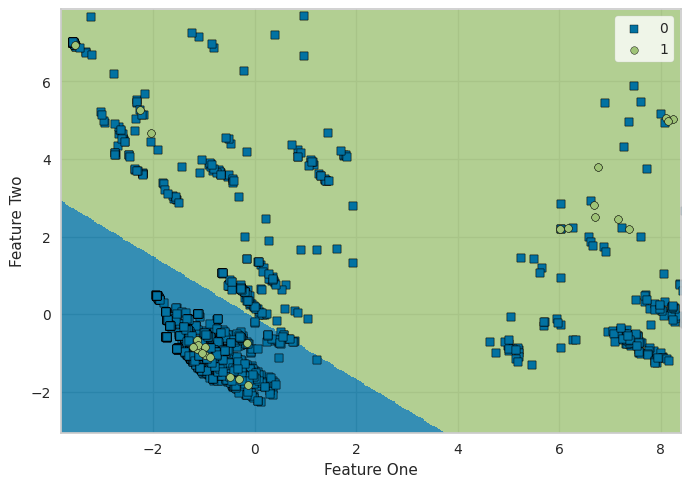

In [0]:
plot_model(best_ensemble_tuned, plot='boundary')

## Explain Best Model

In [0]:
predictions = predict_model(best_ensemble_tuned)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.9321,0.8749,0.2,0.0619,0.0945,0.0693,0.0825


In [0]:
final_model = finalize_model(best_ensemble_tuned)
save_model(final_model, 'safety_incidents_predictor2')

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['constrained_stops', 'breakdowns',
                                              'planned_count', 'unplanned_count',
                                              'duration_sum',
                                              'constrained_stops_per_day',
                                              'planned_stops_per_day',
                                              'unplanned_stops_per_day',
                                              'total_defects',
                                              'total_defects_yesterday',
                                              'num_resolved_in_24_hours',
                                              'per_resolved_...
                                     transformer=StandardScaler(copy=True,
                                                                with_mean=Tru

In [0]:
saved_model = load_model('safety_incidents_predictor2')
X_pipe = saved_model[:-1].transform(ml_df_class).drop(columns='is_near_miss')
shap_model = saved_model.named_steps['actual_estimator']

Transformation Pipeline and Model Successfully Loaded


In [0]:
# explainer = shap.KernelExplainer(shap_model.predict_proba, shap.kmeans(X_pipe, 10))
# shap_values = explainer.shap_values(X_pipe)
sample_size = min(100, len(X_pipe))  # Use max 100 samples
X_sample = X_pipe.sample(n=sample_size, random_state=42)

# Use fewer background samples
background_size = min(50, len(X_pipe))
background_data = shap.kmeans(X_pipe, background_size)

explainer = shap.KernelExplainer(shap_model.predict_proba, background_data)
shap_values = explainer.shap_values(X_sample)

print(f"Using sample of {sample_size} observations with {background_size} background samples")

  0%|          | 0/100 [00:00<?, ?it/s]

Using sample of 100 observations with 50 background samples


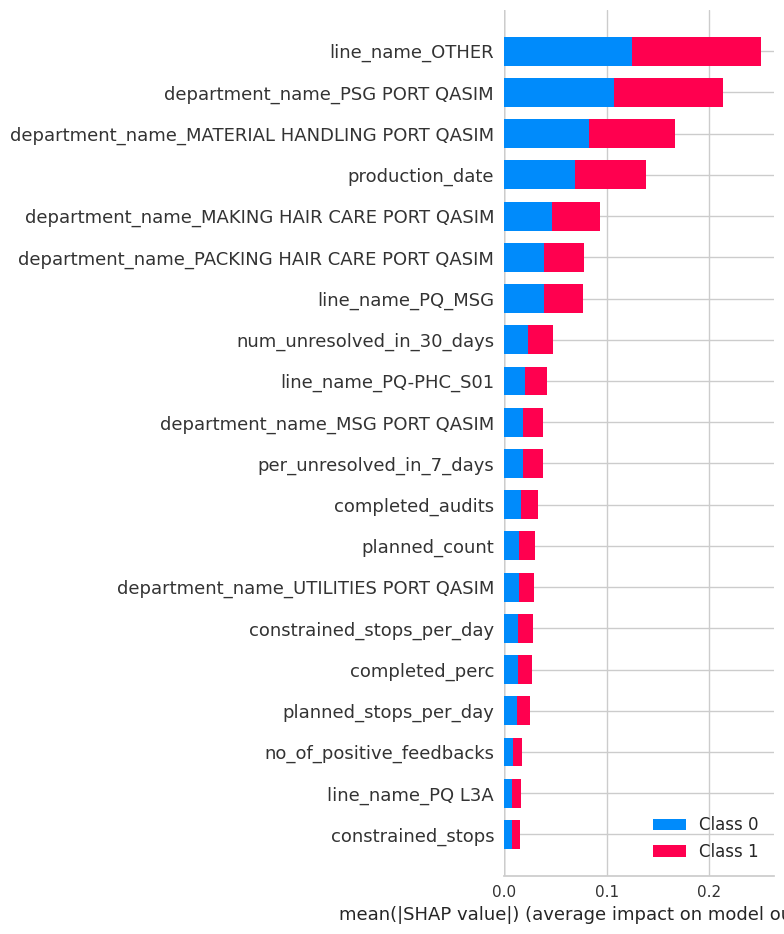

In [0]:
shap.summary_plot(shap_values, X_pipe)

In [0]:
shap.plots.waterfall(explainer(X_pipe.iloc[0]))

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
File <command-1817494140045060>, line 1
----> 1 shap.plots.waterfall(explainer(X_pipe.iloc[0]))

File /local_disk0/.ephemeral_nfs/envs/pythonEnv-7d93f862-3c69-4eeb-b8fb-df5c31e80574/lib/python3.11/site-packages/shap/plots/_waterfall.py:69, in waterfall(shap_values, max_display, show)
     62 if len(sv_shape) != 1:
     63     emsg = (
     64         "The waterfall plot can currently only plot a single explanation, but a "
     65         f"matrix of explanations (shape {sv_shape}) was passed! Perhaps try "
     66         "`shap.plots.waterfall(shap_values[0])` or for multi-output models, "
     67         "try `shap.plots.waterfall(shap_values[0, 0])`."
     68     )
---> 69     raise ValueError(emsg)
     71 base_values = float(shap_values.base_values)
     72 features = shap_values.display_data if shap_values.display_data is not Non